# What drives hurricane impacts? -- Perspectives beyond hurricane frequency and intensity

In [3]:
import os
cwd=os.getcwd()

cwd_data=cwd+'/data'

if not os.path.exists(cwd_data):
    os.mkdir(cwd_data)

In [4]:
%%capture
# These uninstallation must be done to ensure that no version conflicts would happen.
!pip uninstall --yes cartopy
!pip uninstall --yes shapely
# Shapely and cartopy are used for graphing maps and tracks.
!pip install shapely cartopy
!pip install gender_guesser

In [5]:
import cartopy.crs as ccrs # used for map projection
import matplotlib.pyplot as plt # matplotlib
import cartopy.feature as cfeature # used for map projection
import xarray as xr # x-array
import numpy as np # numpy
import pandas as pd
import urllib.request # download request
import warnings # to suppress warnings
import gender_guesser.detector as gender # for analyzing the names of hurricanes
from numpy import linalg as LA # to plot the moments (by calculating the eigenvalues)
from sklearn.cluster import k_means # to perform k-means
from collections import Counter # set operations
warnings.filterwarnings('ignore')
import seaborn as sns
from scipy.stats import spearmanr

# 1. Alignment between track shape clusters with hurricane destruction

## 1.1 Data Loading

### 1.1.1 Hurricane data

In [6]:
import requests

# IBTrACS.NA.v04r00.nc presents data from 1842-10-25 through 2023-06-07 
url = 'https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.NA.v04r00.nc'
output_file = 'data/NA_data.nc'

try:
    response = requests.get(url, timeout=60)
    response.raise_for_status()  # Raise an error for HTTP codes >= 400
    with open(output_file, 'wb') as f:
        f.write(response.content)
    print("File downloaded successfully.")
except requests.exceptions.RequestException as e:
    print(f"Request failed: {e}")

File downloaded successfully.


In [7]:
# Download the needed track file
filedata = urllib.request.urlopen('https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.NA.v04r00.nc')

datatowrite = filedata.read()

with open('data/NA_data.nc', 'wb') as f:   
    f.write(datatowrite)

In [8]:
tks = xr.open_dataset('data/NA_data.nc', engine="netcdf4", decode_times=False)

#filter data down to 1980 to 2024 to match data in destruction dataset
storms = tks.where(tks.season > 1979)

for x in range(len(storms.name.values)):
    storms.name.values[x] = str(storms.name.values[x])[2:-1]

#focus on named storms
storms_subset = storms.where(storms.name != '', drop=True)
storms_subset = storms_subset.where(storms_subset.name != 'NOT_NAMED', drop=True)

### 1.1.2 Destruction data

In [9]:
#loading death & destruction info
destruction_data = pd.read_csv("data/hurricane_events-US-1980-2024.csv")

#format storm naming to match NA_data format
destruction_data['NA_name'] = destruction_data.Name.str.split().str[1]
destruction_data['year'] = destruction_data['Begin Date'].astype(str).str.slice(0, 4)
for value in range(len(destruction_data.NA_name)):
    if destruction_data.NA_name[value] == 'Storm':
        destruction_data['NA_name'][value] = destruction_data.Name.str.split().str[2]
        
destruction_data['NA_name'] = destruction_data['NA_name'].str.upper()
destruction_data

,Name,Disaster,Begin Date,End Date,CPI-Adjusted Cost,Unadjusted Cost,Deaths,NA_name,year
0,Hurricane Allen (August 1980),Tropical Cyclone,19800807,19800811,2236.2,590.0,13,ALLEN,1980
1,Hurricane Alicia (August 1983),Tropical Cyclone,19830817,19830820,9450.0,3000.0,21,ALICIA,1983
2,Hurricane Elena (September 1985),Tropical Cyclone,19850830,19850903,3788.4,1297.4,4,ELENA,1985
3,Hurricane Gloria (September 1985),Tropical Cyclone,19850926,19850928,2491.3,856.1,11,GLORIA,1985
4,Hurricane Juan (October 1985),Tropical Cyclone,19851027,19851031,4340.4,1496.7,63,JUAN,1985
...,...,...,...,...,...,...,...,...,...
62,Hurricane Beryl (July 2024),Tropical Cyclone,20240708,20240708,7219.0,7219.0,46,BERYL,2024
63,Hurricane Debby (August 2024),Tropical Cyclone,20240805,20240809,2476.0,2476.0,17,DEBBY,2024
64,Hurricane Francine (September 2024),Tropical Cyclone,20240911,20240912,1291.0,1291.0,0,FRANCINE,2024
65,Hurricane Helene (September 2024),Tropical Cyclone,20240924,20240929,78721.0,78721.0,219,HELENE,2024


In [10]:
#Add destruction data to storm_subset xarray

#need to add two variables to storms_subset: CPI Adjusted Cost & Deaths
dummy_var = np.zeros(len(storms_subset['name']))
dummy_var2 = np.zeros(len(storms_subset['name']))
storms_subset['CPI_adj_costs'] = (['storm'],  dummy_var)
storms_subset['deaths'] = (['storm'],  dummy_var2)
storms_subset

#update values in storms_subsets with CPI adj costs & deaths
for x in range(len(storms_subset['name'])):
#    print(x)
    test_s = str(storms_subset.name[x].values)
    year_s = str(int(storms_subset.season[x].values))
#    print(year_s)
    costs_s = destruction_data['CPI-Adjusted Cost'][(destruction_data['NA_name'] == test_s)&(destruction_data['year'] == year_s)]
    deaths_s = destruction_data['Deaths'][(destruction_data['NA_name'] == test_s)&(destruction_data['year'] == year_s)]

    if any(costs_s > 0):
#        print('working')
        storms_subset.CPI_adj_costs.values[x] = costs_s
    if any(deaths_s > 0):
        storms_subset.deaths.values[x] = deaths_s
    #storms_subset.deaths

storms_subset        

<xarray.Dataset> Size: 147MB
Dimensions:           (storm: 581, date_time: 360, quadrant: 4)
Coordinates:
    time              (storm, date_time) float64 2MB ...
    lat               (storm, date_time) float32 837kB ...
    lon               (storm, date_time) float32 837kB ...
Dimensions without coordinates: storm, date_time, quadrant
Data variables: (12/149)
    numobs            (storm) float32 2kB 91.0 47.0 43.0 ... 31.0 49.0 106.0
    sid               (storm) object 5kB b'1980214N11330' ... b'2023292N13309'
    season            (storm) float32 2kB 1.98e+03 1.98e+03 ... 2.023e+03
    number            (storm) float32 2kB 57.0 62.0 63.0 69.0 ... 62.0 67.0 70.0
    basin             (storm, date_time) object 2MB b'NA' b'NA' ... b'' b''
    subbasin          (storm, date_time) object 2MB b'NA' b'NA' ... b'' b''
    ...                ...
    usa_seahgt        (storm, date_time) float32 837kB nan nan nan ... nan nan
    usa_searad        (storm, date_time, quadrant) float32 3MB nan nan ... nan
    storm_speed       (storm, date_time) float32 837kB 22.0 22.0 ... nan nan
    storm_dir         (storm, date_time) float32 837kB 267.0 267.0 ... nan nan
    CPI_adj_costs     (storm) float64 5kB 2.236e+03 0.0 0.0 0.0 ... 0.0 0.0 0.0
    deaths            (storm) float64 5kB 13.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/49)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    history:                    Tue May 28 04:28:18 2024: ncks --no_abc --cnk...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    NCO:                        netCDF Operators version 4.8.1 (Homepage = ht...

### 1.1.3 Visualize hurricane destruction

most named hurricanes since 1980 cause limited destruction in terms of damage & lives lost. A relative few storms cause strong damage. Genearlly damage and deaths are positively correlated, with a wider range of destruction costs. Katrina & Harvey are outliers in lives lost

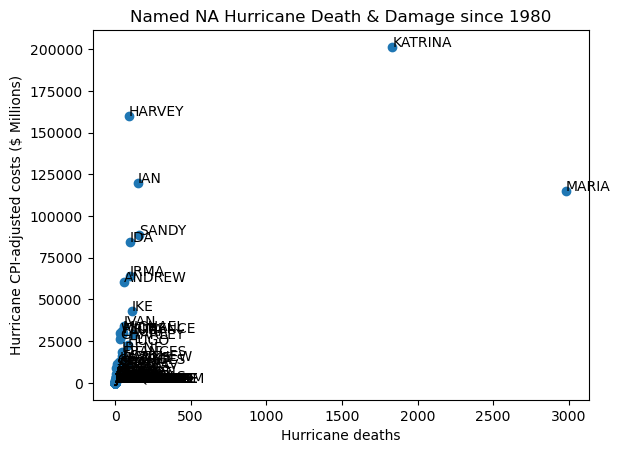

In [11]:
#scatter of deaths by CPI_adj_costs
fig, ax = plt.subplots()
ax.scatter(storms_subset.deaths, storms_subset.CPI_adj_costs)
ax.set_xlabel('Hurricane deaths')
ax.set_ylabel('Hurricane CPI-adjusted costs ($ Millions)')
ax.set_title('Named NA Hurricane Death & Damage since 1980')

for i, txt in enumerate(storms_subset.name.values):
    ax.annotate(txt, (storms_subset.deaths[i], storms_subset.CPI_adj_costs[i]))
plt.show()

## 1.2 K-means clustering using moments

In [12]:
def map_background(label=False, extent=[-100, 0, 0, 60]):
  # A helpder function for creating the map background.
  # INPUT:
  # "extent": corresponds to the location information of the showed map.
  # "label": boolean

  # OUTPUT:
  # Matplotlib AXES object

  plt.figure(figsize = (20, 10))
  ax = plt.axes(projection=ccrs.PlateCarree())
  ax.coastlines()
  ax.set_extent(extent)
  ax.gridlines(draw_labels=label) # show labels or not
  LAND = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                      edgecolor='face',
                                      facecolor=cfeature.COLORS['land'],
                                          linewidth=.1)
  OCEAN = cfeature.NaturalEarthFeature('physical', 'ocean', '10m',
                                       edgecolor='face',
                                       facecolor=cfeature.COLORS['water'], linewidth=.1)
  ax.add_feature(LAND, zorder=0)
  ax.add_feature(OCEAN)
  return ax

In [13]:
# These are helper functions to conveniently plot one single track.
def get_lon_lat(storm):
  lon_lst = storm.lon.values
  lat_lst = storm.lat.values
  return lon_lst[~np.isnan(lon_lst)], lat_lst[~np.isnan(lat_lst)]

# !!! Note that even though it's a convention to place latitude before longitude,
# to work with cartopy projection, longitude MUST be placed first. !!!
def plot_one_track(ax, storm, color='blue', all_track=True, marker_color='black'):
  # INPUT:
  # ax: Matplotlib axes object
  # storm: a Xarray DATASET object (this can be adjusted if desired)
  # all_track: plot the whole track or just the origin

  # OUTPUT:
  # None

  lon_lst, lat_lst = get_lon_lat(storm)
  year = storm.season.values
  if all_track:
    ax.plot(lon_lst, lat_lst, '-o', color=color, linewidth=2, markersize=3) # marker='.'
    ax.plot(lon_lst[-1], lat_lst[-1], color=marker_color, marker='x', markersize=10)
  ax.plot(lon_lst[0], lat_lst[0], color=marker_color, marker='*', markersize=10)
  ax.text(lon_lst[0], lat_lst[0]-2, str(storm.name.values), horizontalalignment='center')


In [14]:
def get_moments(storm):
  # A function to calculate the track moments given a storm
  # OUTPUT:
  # X-centroid, Y-centroid, X_var, Y_var, XY_var

  # Note that:
  # In this case, no weights are set. In other words, all weights are 1.
  # A weight variable would need to be added in order to explore other weights

  lon_lst, lat_lst = get_lon_lat(storm)
  # If the track only has one point, there is no point in calculating the moments
  if len(lon_lst)<= 1: return None
      
  # M1 (first moment = mean). 
  # No weights applied
  lon_weighted, lat_weighted = np.mean(lon_lst), np.mean(lat_lst)
    
  # M2 (second moment = variance of lat and of lon / covariance of lat to lon
  # No weights applied
  cv = np.ma.cov([lon_lst, lat_lst])
    
  return [lon_weighted, lat_weighted, cv[0, 0], cv[1, 1], cv[0, 1]]

In [15]:
#running clustering based on path (1st & 2nd moments) for named hurricanes since 1980
moment_lst = [get_moments(storms_subset.sel(storm=i)) for i in range(storms_subset.dims['storm'])
              if get_moments(storms_subset.sel(storm=i))]
#run for subset with just named storms

print(np.shape(moment_lst))
print(f"There are {storms_subset.dims['storm']-np.shape(moment_lst)[0]} tracks that have length less than 1.")

(581, 5)
There are 0 tracks that have length less than 1.


### 1.2.1 Find inertia values to determine the right number of clusters

Text(0.5, 1.0, 'Inertia Values against the Number of Cluster k')

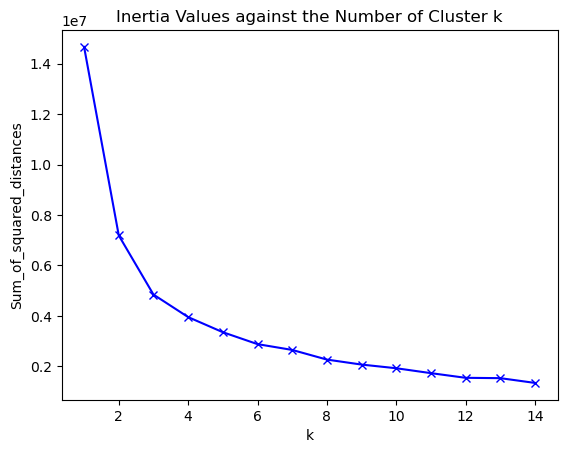

In [16]:
#running for since 1979
sum_of_squares = []
K = range(1, 15)
for k in K:
    km = k_means(moment_lst, n_clusters=k)
    sum_of_squares.append(km[2])
plt.plot(K, sum_of_squares, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Inertia Values against the Number of Cluster k')

### 1.2.2 Visualize cluster tracks

Text(0.5, 1.0, 'K-means clustering result on path, 6 clusters')

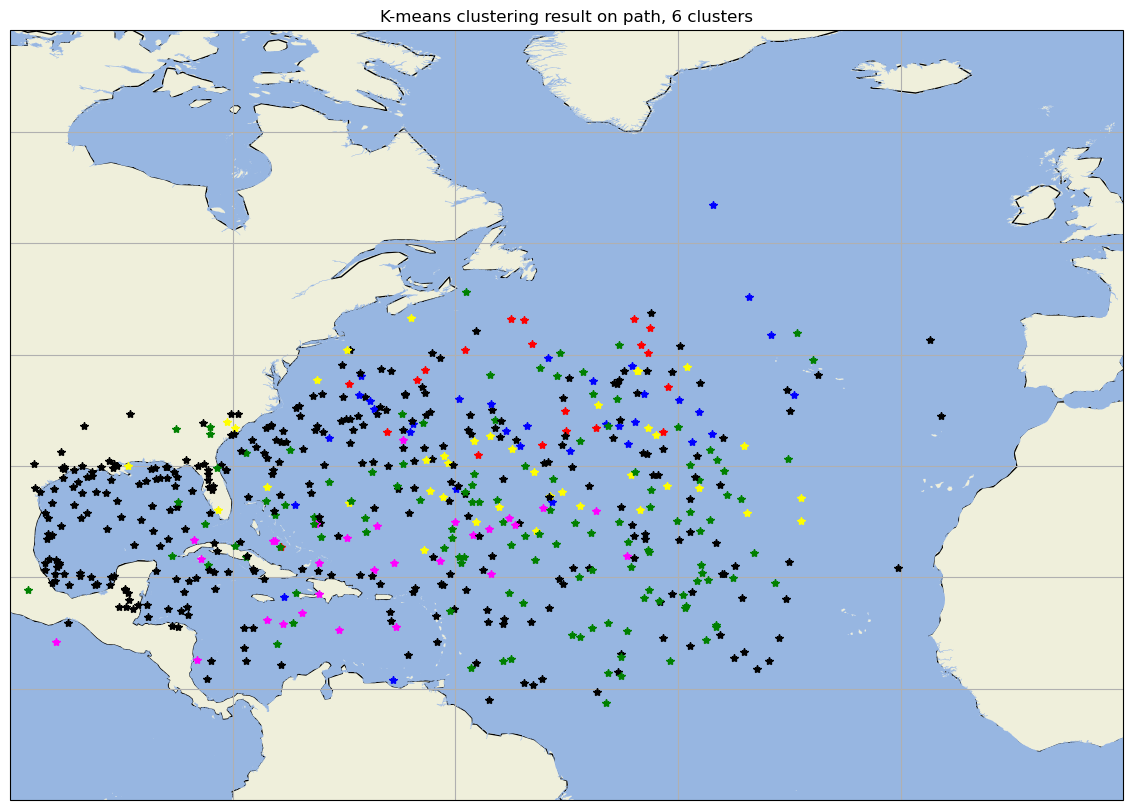

In [17]:
#for storms since 1979, cluster based on path (1st and 2nd moment)
km = k_means(moment_lst, n_clusters=6)

#same graph as in the paper, but with only named storms since 1980. Fairly similar clustering
colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta']
labels = km[1]
ax = map_background()
for k in range(len(moment_lst)):
    ax.plot(moment_lst[k][0], moment_lst[k][1], c=colors[labels[k]], marker='*')

plt.title('K-means clustering result on path, 6 clusters')

### 1.2.3 Add clusters to storms_subset

In [18]:
#adding cluster information
dummy_var3 = np.zeros(len(storms_subset['name']))
storms_subset['cluster_path'] = (['storm'],  dummy_var3)

for i in range(len(km[1])):
    storms_subset.cluster_path[i] = km[1][i]
#    print(km[1][i], storms_subset.cluster_path.values[i])

dummy_var4 = np.zeros(len(storms_subset['name']))
storms_subset['one_moment'] = (['storm'],  dummy_var4)
dummy_var5 = np.zeros(len(storms_subset['name']))
storms_subset['two_moment'] = (['storm'],  dummy_var5)

for i in range(len(moment_lst)):
    storms_subset.one_moment[i] = moment_lst[i][0]
    storms_subset.two_moment[i] = moment_lst[i][1]

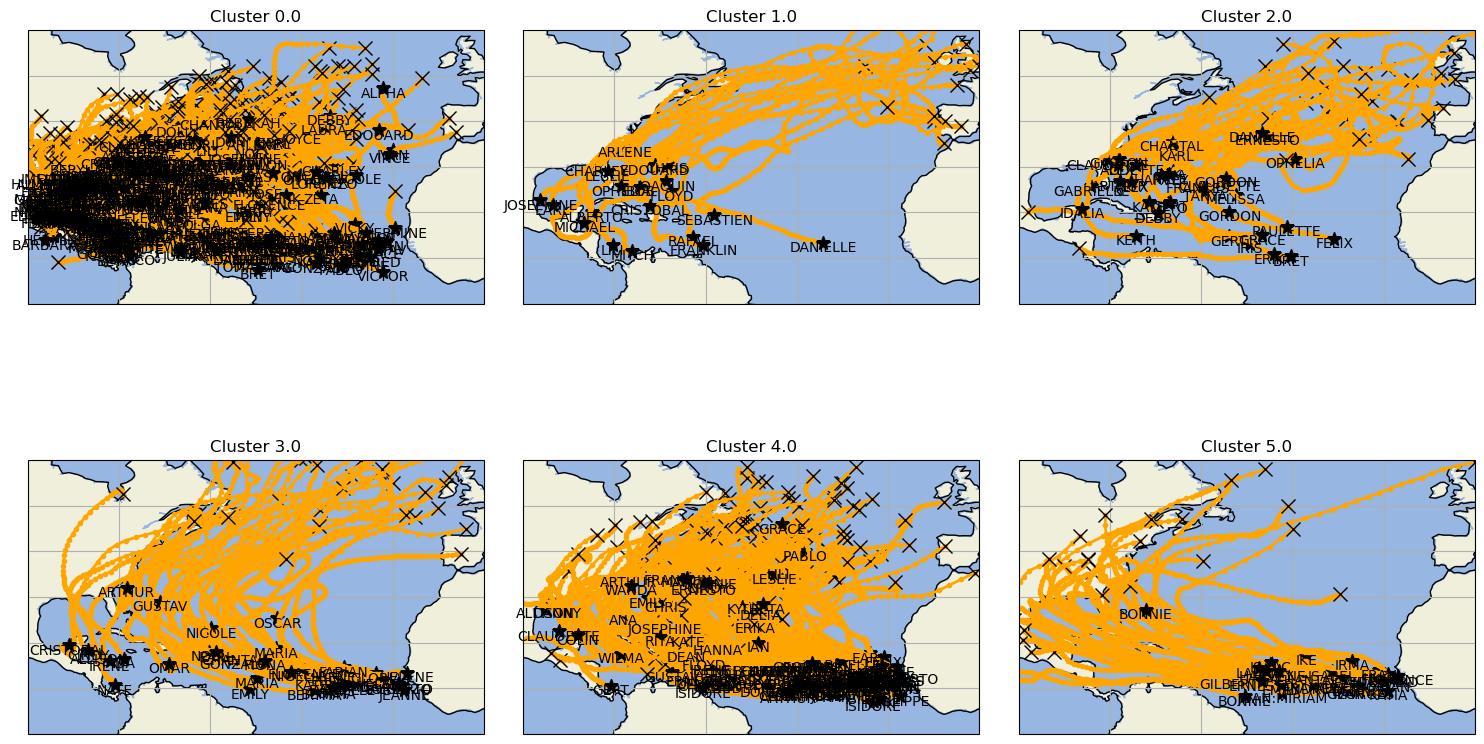

In [19]:
def multi_map_background(ax, label=False, extent=[-100, 0, 0, 60]):
    
    ax.set_extent(extent, crs=ccrs.PlateCarree())  
    ax.coastlines()  
    ax.gridlines(draw_labels=label)  

    land = cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                        edgecolor='face', facecolor=cfeature.COLORS['land'])
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '10m', 
                                         edgecolor='face', facecolor=cfeature.COLORS['water'])
    ax.add_feature(land, zorder=0)
    ax.add_feature(ocean, zorder=0)
    
    return ax

unique_clusters = np.unique(storms_subset.cluster_path.values)
fig, axes = plt.subplots(2, 3, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for i, cluster_id in enumerate(unique_clusters):
    ax = axes[i]
    ax = multi_map_background(ax, extent=[-100, 0, 0, 60])  # 传入 ax
    cluster_storms = storms_subset.where(storms_subset.cluster_path == cluster_id, drop=True)
    
    for ind in range(cluster_storms.dims["storm"]):
        storm = cluster_storms.sel(storm=ind)
        plot_one_track(ax, storm, color="orange")

    ax.set_title(f"Cluster {cluster_id}")

plt.tight_layout()
plt.show()

## 1.3 Cluster profiles of destructive storms

### 1.3.1 Frequency distribution

In [20]:
# 50 storms with damage & aligned over 2 datasets
storms_damage = storms_subset.where(storms_subset.CPI_adj_costs > 0, drop=True)
storms_damage

<xarray.Dataset> Size: 13MB
Dimensions:           (storm: 50, date_time: 360, quadrant: 4)
Coordinates:
    time              (storm, date_time) float64 144kB ...
    lat               (storm, date_time) float32 72kB ...
    lon               (storm, date_time) float32 72kB ...
Dimensions without coordinates: storm, date_time, quadrant
Data variables: (12/152)
    numobs            (storm) float32 200B 91.0 48.0 64.0 ... 74.0 47.0 104.0
    sid               (storm) object 400B b'1980214N11330' ... b'2023239N21274'
    season            (storm) float32 200B 1.98e+03 1.983e+03 ... 2.023e+03
    number            (storm) float32 200B 57.0 47.0 79.0 ... 35.0 46.0 46.0
    basin             (storm, date_time) object 144kB b'NA' b'NA' ... b'' b''
    subbasin          (storm, date_time) object 144kB b'NA' b'NA' ... b'' b''
    ...                ...
    storm_dir         (storm, date_time) float32 72kB 267.0 267.0 ... nan nan
    CPI_adj_costs     (storm) float64 400B 2.236e+03 9.45e+03 ... 3.56e+03
    deaths            (storm) float64 400B 13.0 21.0 4.0 11.0 ... 152.0 5.0 5.0
    cluster_path      (storm) float64 400B 5.0 0.0 0.0 3.0 ... 3.0 0.0 0.0 2.0
    one_moment        (storm) float64 400B -72.22 -95.42 ... -75.77 -71.34
    two_moment        (storm) float64 400B 18.46 31.26 28.92 ... 27.36 32.52
Attributes: (12/49)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    history:                    Tue May 28 04:28:18 2024: ncks --no_abc --cnk...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    NCO:                        netCDF Operators version 4.8.1 (Homepage = ht...

Text(0.5, 1.0, 'Path of USA Damaging Storms')

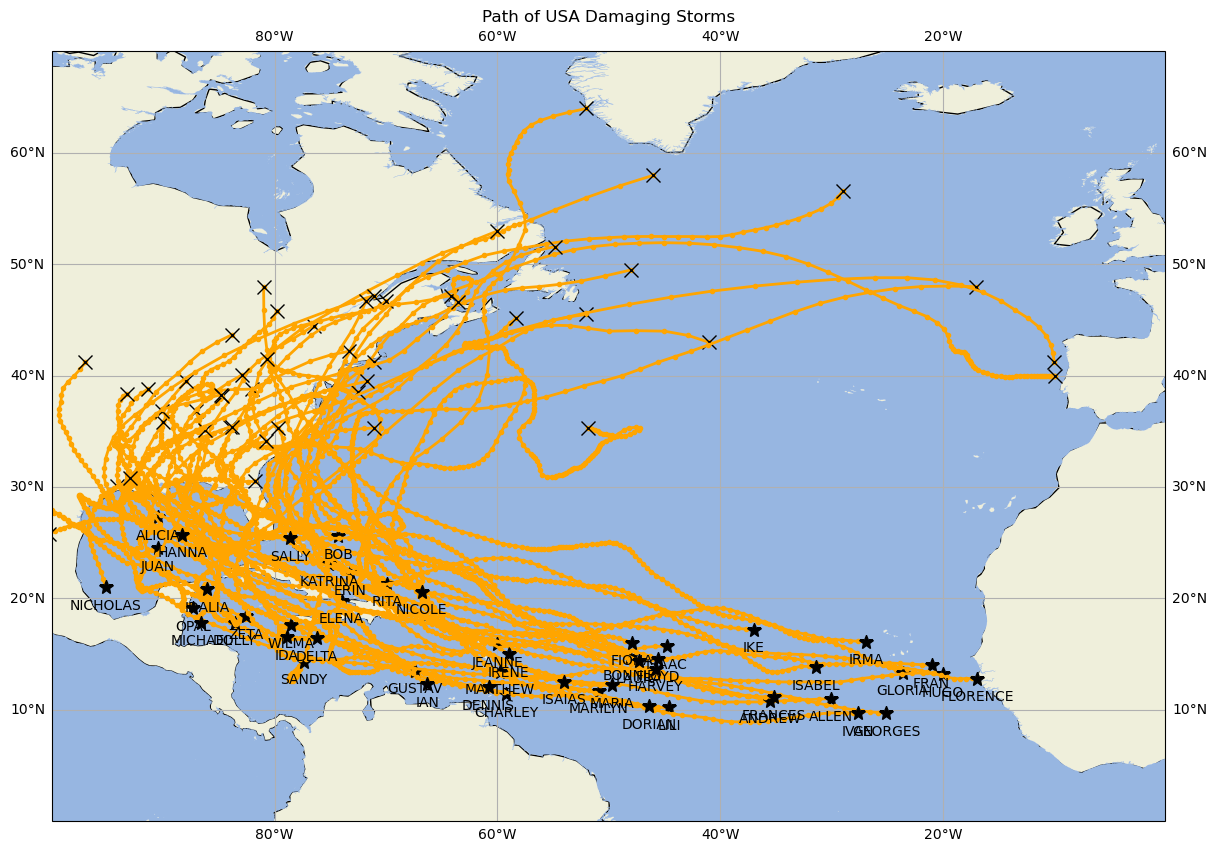

In [21]:
storm_num = storms_damage.dims['storm']
ax = map_background(extent=[-100, 0, 0, 60], label=True)

for ind in range(storm_num):
  storm = storms_damage.sel(storm=ind)
  plot_one_track(ax, storm, color='orange')
plt.title(f"Path of USA Damaging Storms")

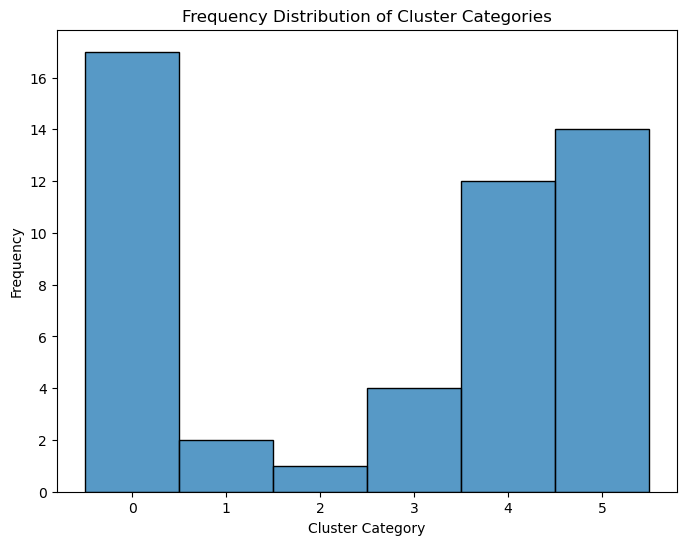

In [22]:
# Frequency distribution of destructive storms for different clusters
plt.figure(figsize=(8, 6))
sns.histplot(storms_damage.cluster_path, bins=6, discrete=True, kde=False)

plt.xlabel("Cluster Category")
plt.ylabel("Frequency")
plt.title("Frequency Distribution of Cluster Categories")
plt.show()

### 1.3.2 Intensity of different clusters

It's not the cluster with strongest intensity account for the largest proportion of destructive storms; instead, the least intense storms make up the largest portion

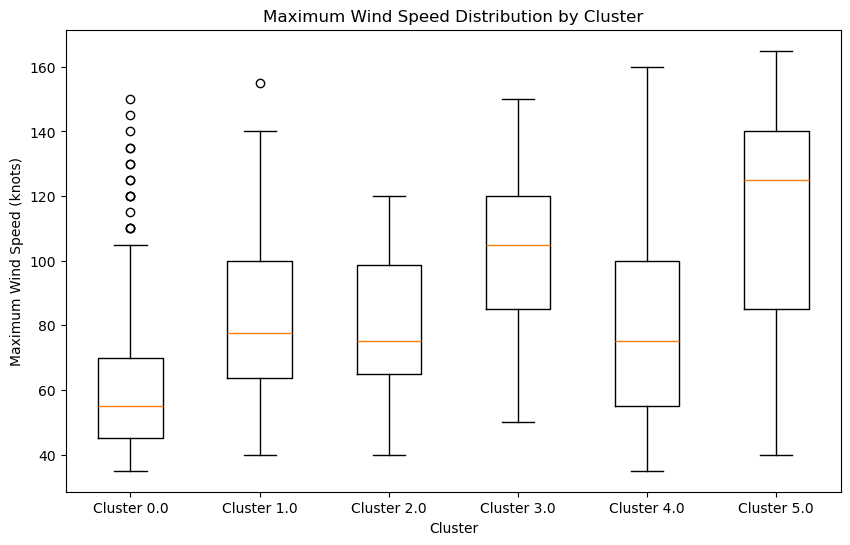

In [23]:
# Create a list to store max wind speed data for each cluster
cluster_wind_data = []

for cluster in unique_clusters:
    cluster_data = storms_subset.where(storms_subset.cluster_path == cluster, drop=True)
    
    # Process each storm's max wind speed
    cluster_wind_list = []
    for storm_wind in cluster_data['usa_wind']:
        # Remove NaNs and find the max wind speed for this storm
        valid_wind = storm_wind[~np.isnan(storm_wind)]
        if len(valid_wind) > 0:
            cluster_wind_list.append(valid_wind.max().values)
    
    # Add to data only if the cluster_wind_list is not empty
    if cluster_wind_list:
        cluster_wind_data.append(cluster_wind_list)

# Make boxplots
plt.figure(figsize=(10, 6))
plt.boxplot(cluster_wind_data, labels=[f'Cluster {c}' for c in unique_clusters if len(cluster_wind_data[unique_clusters.tolist().index(c)]) > 0])
plt.title('Maximum Wind Speed Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Maximum Wind Speed (knots)')
plt.show()

### 1.3.3 Total CPI Adjusted Costs by Cluster

The relative proportion of the most intense storm cluster increases, indicating generally more damaged induced by stronger storms. However, the least intense storms still make up the majority of total cost (varies as rerunning the code)

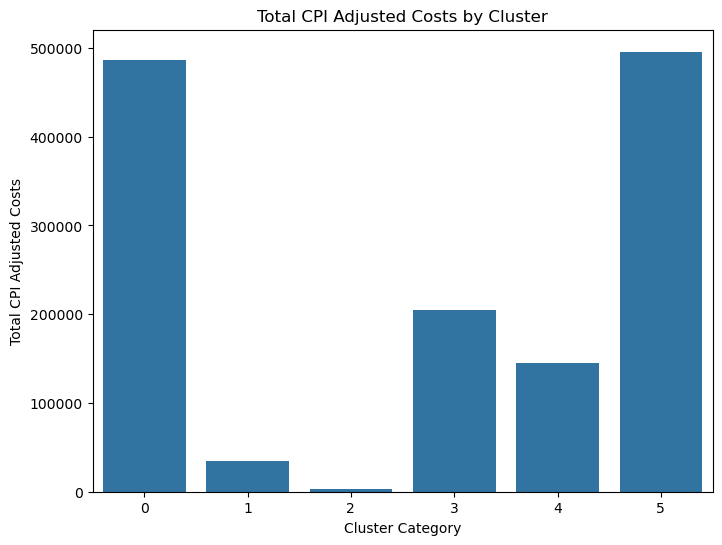

In [25]:
cluster_costs = storms_damage.CPI_adj_costs.groupby(storms_damage.cluster_path).sum().to_pandas()

all_clusters = pd.Series(index=range(6), data=0.0)  # 创建0-5索引
cluster_costs = all_clusters.add(cluster_costs, fill_value=0)  # 填充缺失类别

# Make boxplots
plt.figure(figsize=(8, 6))
sns.barplot(x=cluster_costs.index, y=cluster_costs.values)
plt.xlabel("Cluster Category")
plt.ylabel("Total CPI Adjusted Costs")
plt.title("Total CPI Adjusted Costs by Cluster")
plt.show()

Storm intensity alone cannot fully explain the destruction profile, and additional perspectives are needed.

# 2. Regression incorporating population, GDP and other factors

## 2.1 Data incorporation

### 2.1.1 States & Counties

In [26]:
import geopandas as gpd
from shapely.geometry import Point

# Load state and county shapefiles
states_gdf = gpd.read_file("data/cb_2023_us_state_5m.shp")  # State boundaries
counties_gdf = gpd.read_file("data/cb_2023_us_county_5m.shp")  # County boundaries
us_boundary = gpd.read_file("data/cb_2023_us_nation_5m.shp")  # U.S. boundary

# Ensure all geometries use the same coordinate reference system (CRS)
states_gdf = states_gdf.to_crs(epsg=4326)
counties_gdf = counties_gdf.to_crs(epsg=4326)
us_boundary = us_boundary.to_crs(epsg=4326)  # U.S. national boundary

# Function to get state and county for U.S. landfall points
def get_state_county(lat, lon):
    point = Point(lon, lat)

    # Check if the point is inside the U.S.
    if not us_boundary.contains(point).any():
        return np.nan, np.nan  # Skip non-U.S. points

    # Find the state
    state_match = states_gdf[states_gdf.contains(point)]
    state_name = state_match["NAME"].values[0] if not state_match.empty else None

    # Find the county
    county_match = counties_gdf[counties_gdf.contains(point)]
    county_name = county_match["NAME"].values[0] if not county_match.empty else None

    return state_name, county_name

In [27]:
# Convert storms_damage dataset to structured NumPy arrays
dist2land_vals = storms_damage["dist2land"].values
lat_vals = storms_damage["lat"].values
lon_vals = storms_damage["lon"].values

# Find landfall indices (where dist2land == 0)
landfall_indices = np.where(np.isclose(dist2land_vals, 0))

# Create empty arrays for state and county values
state_var = np.full_like(dist2land_vals, np.nan, dtype=object)
county_var = np.full_like(dist2land_vals, np.nan, dtype=object)

# Compute state and county only for landfall points inside the U.S.
for i, j in zip(*landfall_indices):
    lat, lon = lat_vals[i, j], lon_vals[i, j]

    state, county = get_state_county(lat, lon)

    state_var[i, j] = state
    county_var[i, j] = county

# Add results to the storms_damage dataset
storms_damage["landfall_state"] = (("storm", "date_time"), state_var)
storms_damage["landfall_county"] = (("storm", "date_time"), county_var)

visualize larger storm path

In [28]:
def plot_storm_size(ax, storm, color='yellow',alpha=0.4):
    lon_lst, lat_lst = get_lon_lat(storm)
    year = storm.season.values
    for i in range(len(lon_lst)):
        u = lon_lst[i]
        v = lat_lst[i]
        a = storm['usa_rmw'].values[0][i]/69.17
        b = storm["usa_rmw"].values[0][i]/(69.17*np.cos(np.deg2rad(v)))

        t = np.linspace(0, 2*np.pi, 360)
        plt.fill( u+a*np.cos(t) , v+b*np.sin(t), alpha=0.4, color = 'yellow')

    plt.show()

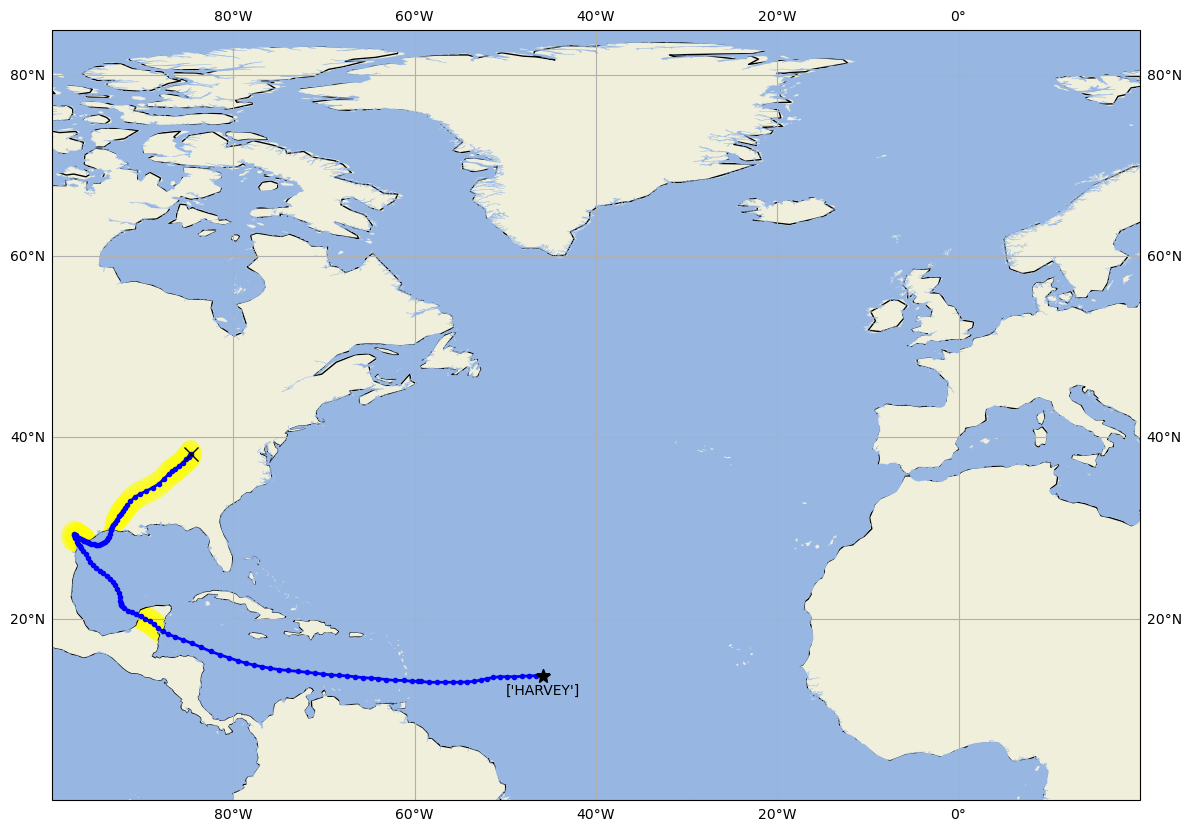

In [29]:
#plot path & storm size
storm_i = storms_subset.where((storms_subset.name=='HARVEY')&(storms_subset.season==2017), drop=True)
lon_weighted, lat_weighted, lon_var, lat_var, xy_var = get_moments(storm_i)

ax = map_background(extent=[-100, 20, 0, 80], label=True)
plot_one_track(ax, storm_i)
plot_storm_size(ax, storm_i)

incoporating populations affected by larger storm path

In [34]:
lat_vals = storms_damage["lat"].values
lon_vals = storms_damage["lon"].values

# Find landfall indices (where dist2land == 0)
landfall_indices = np.where(np.isclose(dist2land_vals, 0))

# Create empty arrays for state and county values
state_var_storm = np.full_like(dist2land_vals, np.nan, dtype=object)
county_var_storm = np.full_like(dist2land_vals, np.nan, dtype=object)

county_list = []
state_list = []
# Compute state and county only for landfall points inside the U.S.
for i, j in zip(*landfall_indices):
    lat, lon = lat_vals[i, j], lon_vals[i, j]
    a = storm['usa_rmw'].values[i]/69.17
    b = storm["usa_rmw"].values[i]/(69.17*np.cos(np.deg2rad(lat)))
    lon_list = np.linspace(lon-a, lon+a, 5)
    lat_list = np.linspace(lat-b, lat+b, 5)
    for d in range(len(lat_list)):
        for e in range(len(lon_list)):
            lat_s = lat_list[d]
            lon_s = lon_list[e]
            state, county = get_state_county(lat_s, lon_s)
            state_list = state_list + [state]
            county_list = county_list + [county]

    state_var_storm[i, j]  = state_list #for each eye of storm location, record full state coverage by storm
    county_var_storm[i, j]  = county_list #for each eye of storm location, record full county coverage by storm
    state_list = [] #reset list
    county_list = [] 

# Add results to the storms dataset
storms_damage["landfall_storm_state"] = (("storm", "date_time"), state_var_storm)
storms_damage["landfall_storm_county"] = (("storm", "date_time"), county_var_storm)

### 2.1.2 Intensity

In [35]:
# Calculate PDI, which considers both max wind speed and life span

# Convert wind speed from knots to meters per second
wind_mps = storms_damage.usa_wind.values * 0.514444

# Initialize an array for storing PDI values
pdi_values = np.full(storms_damage.dims["storm"], np.nan)  # One value per storm

# Loop over each storm
for i in range(storms_damage.dims["storm"]):
    # Extract wind and time data for this storm
    wind_series = wind_mps[i, :]
    time_series = storms_damage.iso_time.values[i, :]

    # Convert time from bytes to datetime, replacing empty values (b'') with NaT
    time_series = np.array([
        pd.to_datetime(t.decode("utf-8")) if isinstance(t, bytes) and t and t.decode("utf-8") else pd.NaT
        for t in time_series
    ])

    # Create a mask for valid wind and time values
    valid_mask = (~np.isnan(wind_series)) & pd.notna(time_series)

    # Filter out invalid values
    valid_wind = wind_series[valid_mask]
    valid_time = time_series[valid_mask]

    # Skip if there are fewer than 2 valid data points
    if len(valid_wind) < 2:
        continue

    # Compute time differences in seconds
    time_deltas = np.diff(valid_time).astype('timedelta64[s]').astype(float)  # Convert to seconds

    # Ensure no negative or NaN time differences
    time_deltas = np.maximum(time_deltas, 0)
    
    # Compute cumulative time in seconds
    cumulative_time = np.cumsum(time_deltas)  # Ensure time is monotonically increasing

    # Compute wind speed cubed
    wind_cubed = valid_wind[:-1] ** 3  # Exclude last point to match `time_deltas`

    # Perform numerical integration using trapezoidal rule
    pdi = np.trapz(wind_cubed, cumulative_time)

    # Scale PDI values and store the result
    pdi_values[i] = pdi * 1e-11

# Add PDI (Intensity) to the storms_damage dataset
storms_damage["Intensity"] = (("storm",), pdi_values)

In [36]:
# calculate PDI after storm hit US land

# Convert wind speed from knots to meters per second
wind_mps = storms_damage.usa_wind.values * 0.514444

# Initialize an array for storing PDI values
pdi_values = np.full(storms_damage.dims["storm"], np.nan)  # One value per storm

# Loop over each storm
for i in range(storms_damage.dims["storm"]):
    # Extract wind, time, and landfall state data for this storm
    wind_series = wind_mps[i, :]
    time_series = storms_damage.iso_time.values[i, :]
    landfall_series = storms_damage.landfall_state.values[i, :]
    
    # Convert time from bytes to datetime, replacing empty values (b'') with NaT
    time_series = np.array([
        pd.to_datetime(t.decode("utf-8")) if isinstance(t, bytes) and t and t.decode("utf-8") else pd.NaT
        for t in time_series
    ])
    
    # Create a mask for valid wind, time, and landfall states (non-NaN landfall)
    valid_mask = (~np.isnan(wind_series)) & pd.notna(time_series) & pd.notna(landfall_series)
    
    # Filter out invalid values
    valid_wind = wind_series[valid_mask]
    valid_time = time_series[valid_mask]
    
    # Skip if there are fewer than 2 valid data points
    if len(valid_wind) < 2:
        continue
    
    # Compute time differences in seconds
    time_deltas = np.diff(valid_time).astype("timedelta64[s]").astype(float)  # Convert to seconds
    
    # Ensure no negative or NaN time differences
    time_deltas = np.maximum(time_deltas, 0)
    
    # Compute cumulative time in seconds
    cumulative_time = np.cumsum(time_deltas)  # Ensure time is monotonically increasing
    
    # Compute wind speed cubed
    wind_cubed = valid_wind[:-1] ** 3  # Exclude last point to match `time_deltas`
    
    # Perform numerical integration using trapezoidal rule
    pdi = np.trapz(wind_cubed, cumulative_time)
    
    # Scale PDI values and store the result
    pdi_values[i] = pdi * 1e-9

# Add PDI (Intensity) to the storms_damage dataset
storms_damage["Intensity_landfall"] = (("storm",), pdi_values)

In [37]:
storms_damage.Intensity_landfall

<xarray.DataArray 'Intensity_landfall' (storm: 50)> Size: 400B
array([ 2.39897464,  2.16927539,  2.52671952,  0.75250439,  5.86208277,
        3.12215258,  0.        ,  4.15104872,  4.49412637,         nan,
        1.67847125,  2.67219133,  4.68207205, 61.66236745,  3.35325499,
        0.98714492,  1.22455553,  5.18323497,  7.05894052,  2.74450443,
       32.34640222,  2.21691696, 18.53539986,  1.67693999,  0.        ,
        3.9348974 ,  2.90710701,  2.77563825, 19.43141049,  3.487702  ,
        1.75360637,         nan,  5.82361448,  4.64795372,  2.92703186,
        4.40215275,  9.57612904,         nan,  1.52288366,  1.93809864,
        5.47395171,  5.4205299 ,  1.96593857,  0.99975958,  7.74614456,
        1.36573619,         nan, 11.54367318,  1.02943236,  3.6126105 ])
Dimensions without coordinates: storm

### 2.1.3 Population

In [38]:
def interpolate_and_extrapolate_population_data(df):
    # Define the range of years from 1980 to 2024
    years = list(range(1980, 2025))
    
    new_df = pd.DataFrame()
    new_df['cty_fips'] = df['cty_fips']
    new_df['cty'] = df['cty']
    
    for year in years:
        if year in df.columns:  # If exact year data exists
            new_df[f'{year}.0'] = df[f'pop_{year}']
        elif year < 2020:  # Interpolation for years between decades
            lower_decade = (year // 10) * 10
            upper_decade = lower_decade + 10

            pop_lower = df[f'pop_{lower_decade}']
            pop_upper = df[f'pop_{upper_decade}']

            weight_upper = (year - lower_decade) / 10
            weight_lower = 1 - weight_upper

            new_df[f'{year}.0'] = (pop_lower * weight_lower + 
                                 pop_upper * weight_upper).round().astype(int)
        else:  # Extrapolation for 2021-2024
            pop_2010 = df['pop_2010']
            pop_2020 = df['pop_2020']
            
            # Compute annual growth rate based on 2010-2020 trend
            annual_growth_rate = (pop_2020 - pop_2010) / 10
            
            # Estimate future population
            new_df[f'{year}.0'] = (pop_2020 + (year - 2020) * annual_growth_rate).round().astype(int)

    year_cols = [str(f'{year}.0') for year in years]
    new_df = new_df[['cty_fips', 'cty'] + year_cols]
    
    return new_df

# Load data and apply function
df = pd.read_csv('data/historical_county_populations_v2.csv')
extrapolated_df = interpolate_and_extrapolate_population_data(df)
extrapolated_df['State'] = extrapolated_df.cty.str.split().str[-1]
extrapolated_df['County'] = extrapolated_df.cty.str.split().str[0]
extrapolated_df

,cty_fips,cty,1980.0,1981.0,1982.0,1983.0,1984.0,1985.0,1986.0,1987.0,...,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0,2024.0,State,County
0,1001,"Autauga County, Alabama",32259,32455,32652,32848,33044,33240,33437,33633,...,57535,57958,58382,58805,59228,59652,60075,60499,Alabama,Autauga
1,1003,"Baldwin County, Alabama",78556,80528,82501,84473,86446,88418,90390,92363,...,216916,221867,226817,231767,236717,241667,246618,251568,Alabama,Baldwin
2,1005,"Barbour County, Alabama",24756,24822,24888,24954,25020,25086,25153,25219,...,25893,25670,25446,25223,25000,24776,24553,24329,Alabama,Barbour
3,1007,"Bibb County, Alabama",15723,15808,15894,15979,16064,16150,16235,16320,...,22480,22417,22355,22293,22231,22169,22106,22044,Alabama,Bibb
4,1009,"Blount County, Alabama",36459,36738,37017,37296,37575,37854,38132,38411,...,58590,58772,58953,59134,59315,59496,59678,59859,Alabama,Blount
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3127,27129,"Renville County, Minnesota",20401,20128,19855,19583,19310,19037,18764,18491,...,15025,14924,14824,14723,14622,14522,14421,14320,Minnesota,Renville
3128,27135,"Roseau County, Minnesota",12574,12819,13064,13310,13555,13800,14045,14290,...,15420,15391,15361,15331,15301,15271,15242,15212,Minnesota,Roseau
3129,27141,"Sherburne County, Minnesota",29908,31112,32315,33519,34723,35926,37130,38334,...,94578,95446,96315,97183,98051,98920,99788,100657,Minnesota,Sherburne
3130,27147,"Steele County, Minnesota",30328,30368,30408,30448,30488,30528,30569,30609,...,37157,37240,37323,37406,37489,37572,37655,37738,Minnesota,Steele


In [46]:
# Convert storms_damage dataset to a pandas DataFrame for easier processing
storms_df = storms_damage.to_dataframe().reset_index()
storms_df['season'] = storms_df['season'].astype(str)  # Ensure season is a string
storms_df['population'] = np.nan 

# Iterate over each unique storm
for storm in storms_df['storm'].unique():
    # Retrieve the season (year) and affected counties for the current storm
    season = storms_df.loc[storms_df['storm'] == storm, 'season'].values[0]
    counties = storms_df.loc[storms_df['storm'] == storm, 'landfall_county'].dropna().unique()  # Get unique counties

    # Ensure the season corresponds to a column in extrapolated_df
    if season in extrapolated_df.columns:
        total_population = extrapolated_df.loc[extrapolated_df['County'].isin(counties), season].sum()
        storms_df.loc[storms_df['storm'] == storm, 'population'] = total_population

# Convert the DataFrame back to an xarray Dataset
storms_updated = storms_damage.copy()
storms_damage['population'] = (('storm',), storms_df.groupby('storm')['population'].first().values)

# View a subset of the results
storms_df[['storm', 'name', 'season', 'population', 'Intensity', 'CPI_adj_costs', 'deaths']].drop_duplicates()

,storm,name,season,population,Intensity,CPI_adj_costs,deaths
0,0,ALLEN,1980.0,406031.0,2.008050,2236.2,13.0
1440,1,ALICIA,1983.0,5031726.0,0.145346,9450.0,21.0
2880,2,ELENA,1985.0,10297395.0,0.425797,3788.4,4.0
4320,3,GLORIA,1985.0,852490.0,0.604994,2491.3,11.0
5760,4,JUAN,1985.0,6587027.0,0.145852,4340.4,63.0
7200,5,HUGO,1989.0,1376356.0,1.385053,22679.7,86.0
8640,6,BOB,1991.0,2200771.0,0.209293,3471.8,18.0
10080,7,ANDREW,1992.0,6953630.0,0.942640,60480.0,61.0
11520,8,ERIN,1995.0,8804953.0,0.145475,1751.0,6.0
12960,9,MARILYN,1995.0,0.0,0.540713,4326.0,13.0


Incoporating larger storm path

In [48]:
storms_df = storms_damage.to_dataframe().reset_index()
storms_df['season'] = storms_df['season'].astype(str)  # Ensure season is a string
storms_df['population_total'] = np.nan
res = []
total_population_storm = 0 

for storm in storms_df['storm'].unique():
    season = storms_df.loc[storms_df['storm'] == storm, 'season'].values[0]
    counties_s = pd.DataFrame(storms_df.loc[storms_df['storm'] == storm, 'landfall_storm_county'].dropna())
    states_s = pd.DataFrame(storms_df.loc[storms_df['storm'] == storm, 'landfall_storm_state'].dropna())

    for i in range(len(counties_s)):
        a = counties_s.iloc[i]
        for b in range(len(a)):
            if a[0][b] not in res:
                res.append(a[0][b])
#    print(res)
    counties_track = res
#    counties_track = counties_track.unique()
    for county in range(len(counties_track)):
        z = res[county]
#        total_population = extrapolated_df.loc[extrapolated_df['County'].isin(counties), season].sum()
        total_population_storm_a = extrapolated_df.loc[extrapolated_df['County']== z, season].sum()
        total_population_storm = total_population_storm + total_population_storm_a 
        storms_df.loc[storms_df['storm'] == storm, 'population_total'] = total_population_storm
    res = []
    total_population_storm = 0 

# Convert the DataFrame back to an xarray Dataset
storms_updated1 = storms_updated.copy()
storms_updated1['population_total'] = (('storm',), storms_df.groupby('storm')['population_total'].first().values)

# View a subset of the results
storms_df[['storm', 'name', 'season', 'Intensity','population_total', 'population','CPI_adj_costs', 'deaths']].drop_duplicates()
#storm_df[

,storm,name,season,Intensity,population_total,population,CPI_adj_costs,deaths
0,0,ALLEN,1980.0,2.008050,0.0,406031.0,2236.2,13.0
1440,1,ALICIA,1983.0,0.145346,2323012.0,5031726.0,9450.0,21.0
2880,2,ELENA,1985.0,0.425797,2138713.0,10297395.0,3788.4,4.0
4320,3,GLORIA,1985.0,0.604994,3545579.0,852490.0,2491.3,11.0
5760,4,JUAN,1985.0,0.145852,1229339.0,6587027.0,4340.4,63.0
7200,5,HUGO,1989.0,1.385053,1760225.0,1376356.0,22679.7,86.0
8640,6,BOB,1991.0,0.209293,2485346.0,2200771.0,3471.8,18.0
10080,7,ANDREW,1992.0,0.942640,7083293.0,6953630.0,60480.0,61.0
11520,8,ERIN,1995.0,0.145475,7050372.0,8804953.0,1751.0,6.0
12960,9,MARILYN,1995.0,0.540713,NaN,0.0,4326.0,13.0


## 2.2 Initial visualization

In [38]:
storms_damage

<xarray.Dataset> Size: 13MB
Dimensions:           (storm: 50, date_time: 360, quadrant: 4)
Coordinates:
    time              (storm, date_time) float64 144kB 4.445e+04 ... nan
    lat               (storm, date_time) float32 72kB 11.0 10.95 ... nan nan
    lon               (storm, date_time) float32 72kB -30.0 -31.11 ... nan nan
Dimensions without coordinates: storm, date_time, quadrant
Data variables: (12/156)
    numobs            (storm) float32 200B 91.0 48.0 64.0 ... 74.0 47.0 104.0
    sid               (storm) object 400B b'1980214N11330' ... b'2023239N21274'
    season            (storm) float32 200B 1.98e+03 1.983e+03 ... 2.023e+03
    number            (storm) float32 200B 57.0 47.0 79.0 ... 35.0 46.0 46.0
    basin             (storm, date_time) object 144kB b'NA' b'NA' ... b'' b''
    subbasin          (storm, date_time) object 144kB b'NA' b'NA' ... b'' b''
    ...                ...
    one_moment        (storm) float64 400B -72.22 -95.42 ... -75.77 -71.34
    two_moment        (storm) float64 400B 18.46 31.26 28.92 ... 27.36 32.52
    landfall_state    (storm, date_time) object 144kB nan nan nan ... nan nan
    landfall_county   (storm, date_time) object 144kB nan nan nan ... nan nan
    Intensity         (storm) float64 400B 2.008 0.1453 ... 0.06817 0.2615
    population        (storm) float64 400B 4.06e+05 5.032e+06 ... 8.831e+05
Attributes: (12/49)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    history:                    Tue May 28 04:28:18 2024: ncks --no_abc --cnk...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    NCO:                        netCDF Operators version 4.8.1 (Homepage = ht...

### 2.2.1 Intensity

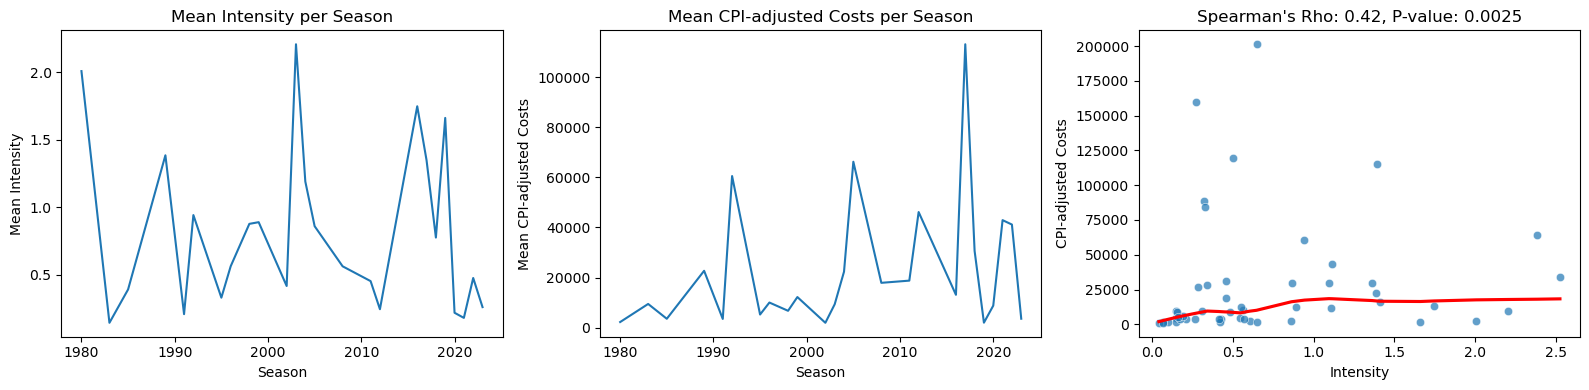

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# 1. group Intensity by season and make plots
storms_damage.Intensity.groupby(storms_damage.season).mean().plot(ax=axes[0])
axes[0].set_title("Mean Intensity per Season")
axes[0].set_xlabel("Season")
axes[0].set_ylabel("Mean Intensity")

# 2. group CPI_adj_costs by season and take the mean
storms_damage.CPI_adj_costs.groupby(storms_damage.season).mean().plot(ax=axes[1])
axes[1].set_title("Mean CPI-adjusted Costs per Season")
axes[1].set_xlabel("Season")
axes[1].set_ylabel("Mean CPI-adjusted Costs")

# 3. scatter plot + LOWESS regression line
rho, p_value = spearmanr(storms_damage.Intensity, storms_damage.CPI_adj_costs)
sns.scatterplot(x=storms_damage.Intensity, y=storms_damage.CPI_adj_costs, alpha=0.7, ax=axes[2])
sns.regplot(x=storms_damage.Intensity.values, y=storms_damage.CPI_adj_costs.values, scatter=False, lowess=True, color='red', ax=axes[2])
axes[2].set_title(f"Spearman's Rho: {rho:.2f}, P-value: {p_value:.2g}")
axes[2].set_xlabel("Intensity")
axes[2].set_ylabel("CPI-adjusted Costs")

plt.tight_layout()
plt.show()

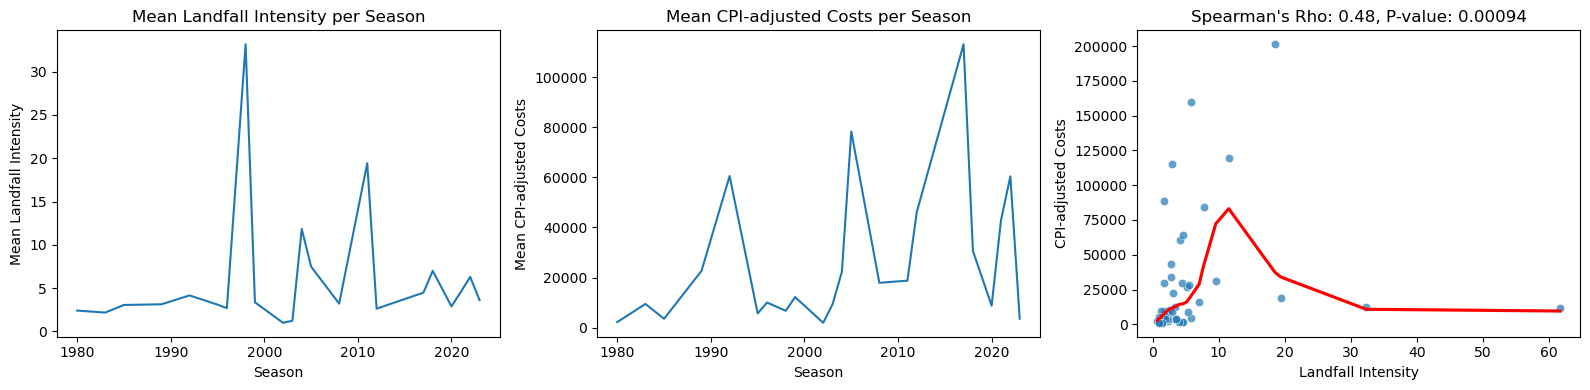

In [77]:
# Using landfall intensity
# filter out lines with NaN and 0
valid_data = storms_damage.where((~np.isnan(storms_damage.Intensity_landfall)) & (storms_damage.Intensity_landfall > 0), drop=True)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

valid_data.Intensity_landfall.groupby(valid_data.season).mean().plot(ax=axes[0])
axes[0].set_title("Mean Landfall Intensity per Season")
axes[0].set_xlabel("Season")
axes[0].set_ylabel("Mean Landfall Intensity")

valid_data.CPI_adj_costs.groupby(valid_data.season).mean().plot(ax=axes[1])
axes[1].set_title("Mean CPI-adjusted Costs per Season")
axes[1].set_xlabel("Season")
axes[1].set_ylabel("Mean CPI-adjusted Costs")

rho, p_value = spearmanr(valid_data.Intensity_landfall, valid_data.CPI_adj_costs)
sns.scatterplot(x=valid_data.Intensity_landfall, y=valid_data.CPI_adj_costs, alpha=0.7, ax=axes[2])
sns.regplot(x=valid_data.Intensity_landfall.values, y=valid_data.CPI_adj_costs.values, scatter=False, lowess=True, color='red', ax=axes[2])
axes[2].set_title(f"Spearman's Rho: {rho:.2f}, P-value: {p_value:.2g}")
axes[2].set_xlabel("Landfall Intensity")
axes[2].set_ylabel("CPI-adjusted Costs")

plt.tight_layout()
plt.show()

### 2.2.2 Frequency

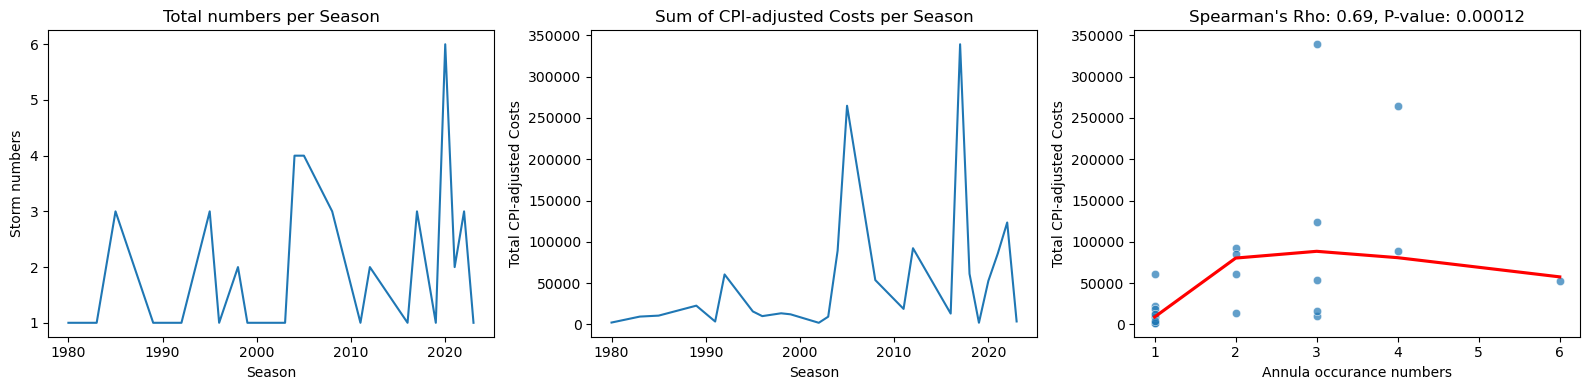

In [48]:
count_yearly = storms_damage.Intensity.groupby(storms_damage.season).count().values
cost_yearly = storms_damage.CPI_adj_costs.groupby(storms_damage.season).sum().values

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

storms_damage.Intensity.groupby(storms_damage.season).count().plot(ax=axes[0])
axes[0].set_title("Total numbers per Season")
axes[0].set_xlabel("Season")
axes[0].set_ylabel("Storm numbers")

storms_damage.CPI_adj_costs.groupby(storms_damage.season).sum().plot(ax=axes[1])
axes[1].set_title("Sum of CPI-adjusted Costs per Season")
axes[1].set_xlabel("Season")
axes[1].set_ylabel("Total CPI-adjusted Costs")

rho, p_value = spearmanr(count_yearly, cost_yearly)
sns.scatterplot(x=count_yearly, y=cost_yearly, alpha=0.7, ax=axes[2])
sns.regplot(x=count_yearly, y=cost_yearly, scatter=False, lowess=True, color='red', ax=axes[2])
axes[2].set_title(f"Spearman's Rho: {rho:.2f}, P-value: {p_value:.2g}")
axes[2].set_xlabel("Annula occurance numbers")
axes[2].set_ylabel("Total CPI-adjusted Costs")

plt.tight_layout()
plt.show()

### 2.2.3 Affected population

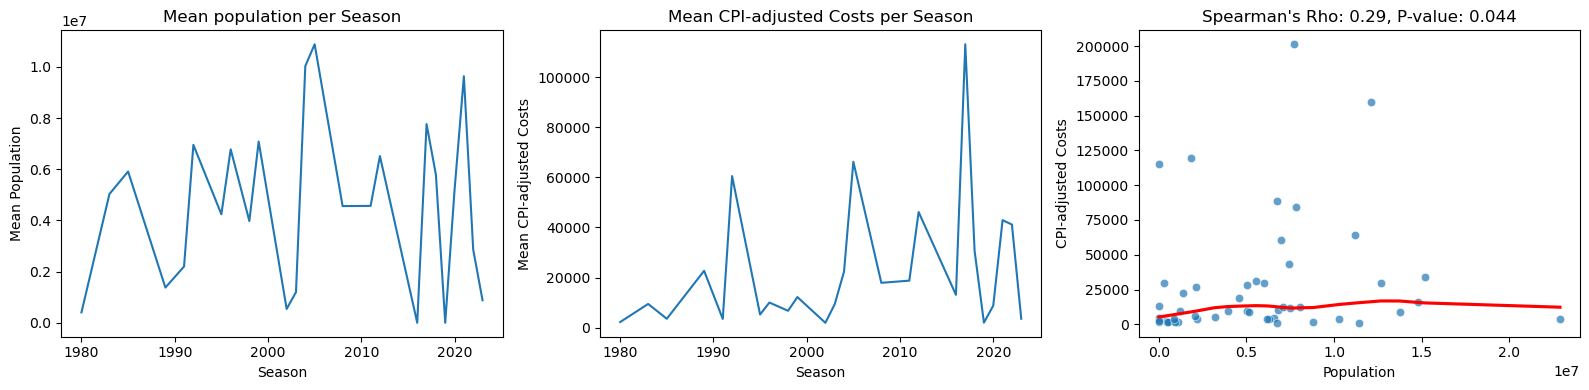

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

storms_damage.population.groupby(storms_damage.season).mean().plot(ax=axes[0])
axes[0].set_title("Mean population per Season")
axes[0].set_xlabel("Season")
axes[0].set_ylabel("Mean Population")

storms_damage.CPI_adj_costs.groupby(storms_damage.season).mean().plot(ax=axes[1])
axes[1].set_title("Mean CPI-adjusted Costs per Season")
axes[1].set_xlabel("Season")
axes[1].set_ylabel("Mean CPI-adjusted Costs")

rho, p_value = spearmanr(storms_damage.population, storms_damage.CPI_adj_costs)
sns.scatterplot(x=storms_damage.population, y=storms_damage.CPI_adj_costs, alpha=0.7, ax=axes[2])
sns.regplot(x=storms_damage.population.values, y=storms_damage.CPI_adj_costs.values, scatter=False, lowess=True, color='red', ax=axes[2])
axes[2].set_title(f"Spearman's Rho: {rho:.2f}, P-value: {p_value:.2g}")
axes[2].set_xlabel("Population")
axes[2].set_ylabel("CPI-adjusted Costs")

plt.tight_layout()
plt.show()